In [25]:
#-*- coding: utf-8 -*-
# This is a version implement a paper:"Detecting Rumors from Microblogs with Recurrent Neural Networks"(https://ijcai.org/Proceedings/16/Papers/537.pdf)
# I change the parameter for my best prediction.
import json,os
from os import listdir
import time
import datetime
import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Neural Network
import numpy as np
np.random.seed(3)
# For add layer sequentally
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [32]:
mypath = "{Path}"

totalData = []
totalDataLabel = []


In [33]:
for filename in glob.glob(mypath):
    name = os.path.splitext(os.path.basename(filename))[0]
    lable = name.split('_')[0]
    totalDoc += 1
    if lable=='N':
        lable=1
    else:
        lable=0
    file = open(os.path.join(mypath,name+'.txt'),"r")
    lines= file.readlines()
    for line in lines:
        row = line.split('\t')
        if len(row)>2:
            totalData.append(row[2])
            totalDataLabel.append(lable)
        
        
len(totalData)

192350

In [34]:
print(totalDataLabel.count(0))
print(totalDataLabel.count(1))


61273
131077


In [35]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)

X = vectorizer.fit_transform(totalData)
type(X)

scipy.sparse.csr.csr_matrix

In [40]:
len(vectorizer.get_feature_names())

41070

In [6]:
#X in the previuos step is hidimentional data, we need to use some dimentionality reduction technique. In this case, we will use SVD (Singular Value Decomposition), which is a common matrix decomposition technique.
#We want to reduce the dimentionality to 5000.
#We have to re-normalize after we run our SVD on the dataset.
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

n_components = 500
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

numpy_mattrix = lsa.fit_transform(X)
type(numpy_mattrix)
feature_count=len(vectorizer.get_feature_names())


In [7]:

tensors = torch.from_numpy(numpy_mattrix)
lables = torch.tensor(totalDataLabel)
tensor_data=torch.utils.data.TensorDataset(tensors,lables)
print(len(tensor_data))
train_size = int(0.8 * len(tensor_data))
test_size = len(tensor_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(tensor_data, [train_size, test_size])
type(train_dataset)


192350


torch.utils.data.dataset.Subset

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
#        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
 #       self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=500, out_features=700)

        self.fc2 = nn.Linear(in_features=700, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=600)
        self.fc4 = nn.Linear(in_features=600, out_features=200)
        self.out = nn.Linear(in_features=200, out_features=2)
        
    def forward(self, t):
    # (1) input layer
        t = t

    # (2) hidden conv layer
        t = self.fc1(t)
        #activation function
        t = F.relu(t)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)

    # (3) hidden conv layer
        t = self.fc2(t)
        t = F.relu(t)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)

    # (4) hidden linear layer
       # t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc3(t)
        t = F.relu(t)

    # (5) hidden linear layer
        t = self.fc4(t)
        t = F.relu(t)

    # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [10]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
model = Network()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100,shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)
torch.enable_grad()
#weights = torch.tensor([1., 10.]) # maximize non roumor detection class
#weights = torch.tensor([9., 1]) # maximize roumor detection class

for epoch in range(0,10):
    total_correct = 0
    total_loss = 0    
    for batch in train_loader: # Get Batch
        tensors, labels = batch 

        preds = model(tensors.float()) # Pass Batch
        optimizer.zero_grad()
        loss = F.cross_entropy(preds, labels) # Calculate Loss

       
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "total_correct:", total_correct, 
        "loss:", total_loss
        )


total_correct: 151384 loss: 81.81062439353263
total_correct: 152530 loss: 39.450154272357395
total_correct: 152139 loss: 80.68713973348713
total_correct: 152677 loss: 44.34256800231287
total_correct: 149786 loss: 179.9179037756112
total_correct: 148013 loss: 189.35408912599087
total_correct: 152923 loss: 26.89639451453695
total_correct: 153105 loss: 22.878892460576026
total_correct: 151736 loss: 96.96241588779958
total_correct: 152964 loss: 29.51427704341677


In [12]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)


In [13]:
test=0
total=0
model.eval()
all_preds = torch.tensor([])
all_lables = torch.tensor([])

for batch in test_loader: # Get Batch
        tensors, labels = batch
        preds = model(tensors.float())
        probs = F.softmax(preds,dim=1)
        test += get_num_correct(probs, labels)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_lables = torch.cat((all_lables, labels.float()),dim=0)

test       

38160

In [14]:
print(len(all_preds.argmax(dim=1)))
len(lables)

38470


192350

In [15]:
print("accuracy: ",test/(len(tensor_data)*0.2))

accuracy:  0.9919417728099819


In [24]:
path='/Users/malam5/Downloads/dataverse_files/normal_classifire.pth'
torch.save(model.state_dict(),path)

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

tensors, original_lables = next(iter(test_loader))

cm = confusion_matrix(all_lables, all_preds.argmax(dim=1))
print(cm)

[[12220   118]
 [  192 25940]]


In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[12220   118]
 [  192 25940]]


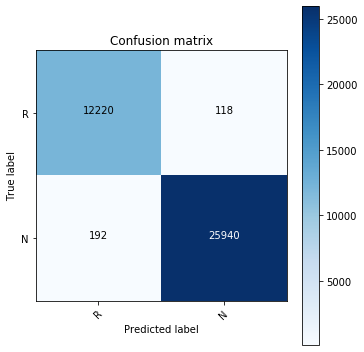

In [19]:

names = (
    'R'
    ,'N'
    )
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, names)

In [20]:
def predict(text):
    model.eval()
    pred = model(text.float())
    probs = F.softmax(pred)
    return probs.detach().numpy()


In [21]:
print(predict(tensors[489])[0])
totalDataLabel[489]

8.709169e-28


/Users/malam5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


1

In [22]:
from lime import lime_text
class_names = ['Rumor', 'Not rumor']

In [23]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
X[50]

<1x41070 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>